# Build Environment

In [1]:
# data set
from keras.datasets import mnist
# plots
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
# models
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn import linear_model # Linear Regression
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam # loss optimizer
from keras.utils import np_utils # categorical variable
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler # adjust learning rate for each layer
import h5py # save model
from keras.models import load_model # load model

# time
import time

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


References: 
1. https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
2. https://medium.com/analytics-vidhya/classification-of-images-based-on-fashion-mnist-dataset-bb11e4bcdefb
3. https://www.kaggle.com/fuzzywizard/fashion-mnist-cnn-keras-accuracy-93

#### Read Data

In [2]:
from keras.datasets import fashion_mnist
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [0]:
'''
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

store names for use later - confusion matrix and plots
'''
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
clothing = {0: 'T-shirt/top',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle boot'}

In [5]:
print(trainX.shape)
print(trainY.shape)

(60000, 28, 28)
(60000,)


In [6]:
print(testX.shape)
print(testY.shape)

(10000, 28, 28)
(10000,)


In [0]:
### SUBSET THE DATA
sub_trainX = trainX[:6000]
sub_trainY = trainY[:6000]
sub_testX = testX[:1000]
sub_testY = testY[:1000]

# Process Data

In [0]:
# process data for non-convolution neural networks
def preprocess_nocnn(train, test, train_lab, test_lab):
  # number of columns = number of pixels
  num_pixels = train.shape[1] * train.shape[2]
  # reshape train and test data - convert to float
  train_x = train.reshape(train.shape[0], num_pixels).astype('float32')
  test_x = test.reshape(test.shape[0], num_pixels).astype('float32')
  # convert to df
  traindf = pd.DataFrame(train_x)
  testdf = pd.DataFrame(test_x)
  # add labels
  traindf.insert(0, 'label', train_lab)
  testdf.insert(0, 'label', test_lab)
  # grab the labels so they have shape (x, ) where x = number of rows
  train_labels = traindf['label']
  test_labels = testdf['label']
  
  # drop labels for models
  traindf.drop(['label'], axis = 1, inplace = True)
  testdf.drop(['label'], axis = 1, inplace = True)
  # verify it does what we want
  print('Train shape: {}'.format(traindf.shape))
  print('Train Labels shape: {}'.format(train_labels.shape))
  print('Test shape: {}'.format(testdf.shape))
  print('Test Labels shape: {}'.format(test_labels.shape))
  # normalize the data to be between 0 and 1
  traindf = traindf/255.0
  testdf = testdf/255.0
  return traindf, train_labels, testdf, test_labels

In [6]:
# get train and test sets and labels
traindf, train_labels, testdf, test_labels = preprocess_nocnn(trainX, testX, trainY, testY)

Train shape: (60000, 784)
Train Labels shape: (60000,)
Test shape: (10000, 784)
Test Labels shape: (10000,)


In [7]:
#bin the clothes
bin_clothing = {0: 'Top',
                1:'Sweater', 
                2:'Shoe',
                3: 'Dress',
                4: 'Bag',
                5: 'Trouser'}
bin_class_names = ['Top', 'Sweater', 'Shoe', 'Dress', 'Bag', 'Trouser']
# t-shirt/top and shirt = top: (0, 6) = 0
# pullover, coat = sweater: (2, 4) = 1
# sandal, sneaker, ankle boot = shoe: (5, 7, 9) = 2
# dress = dress: 3 = 3
# bag = bag: 8 = 4 
bin_train = []
for row in train_labels:
    if (row == 0) or (row == 6):
      row = 0
    elif (row == 2) or (row == 4):
      row = 1
    elif (row == 5) or (row == 7) or (row == 9):
      row = 2
    elif (row == 8):
      row = 4
    elif(row == 3):
      row = 3
    elif(row == 1):
      row = 5
    bin_train.append(row)

bin_test = []
for row in test_labels:
    if (row == 0) or (row == 6):
      row = 0
    elif (row == 2) or (row == 4):
      row = 1
    elif (row == 5) or (row == 7) or (row == 9):
      row = 2
    elif (row == 8):
      row = 4
    elif(row == 3):
      row = 3
    elif(row == 1):
      row = 5
    bin_test.append(row)

# turn lists to a series
bin_train_labels = pd.Series(bin_train)
bin_test_labels = pd.Series(bin_test)
print('Train Labels:', train_labels.shape)
print('Binned Train Labels: ', bin_train_labels.shape)
print('Test Labels: ', test_labels.shape)
print('Binned Test Labels: ', bin_test_labels.shape)

Train Labels: (60000,)
Binned Train Labels:  (60000,)
Test Labels:  (10000,)
Binned Test Labels:  (10000,)


In [0]:
# bin the clothing labels
cnn_bin_train_labels = np.asarray(bin_train_labels)
cnn_bin_test_labels = np.asarray(bin_test_labels)

In [0]:
# process data for convolution neural networks
def preprocess_cnn(train, test, train_lab, test_lab, bin_train_lab, bin_test_lab):
  train_x = train.reshape(train.shape[0], 28, 28, 1)
  test_x = test.reshape(test.shape[0], 28, 28, 1)
  # convert to float
  train_x = train_x.astype('float32')
  test_x = test_x.astype('float32')
  # normalize the data [0,1]
  train_x = train_x/255.0
  test_x = test_x/255.0
  # categorical labels 
  train_y = np_utils.to_categorical(train_lab)
  bin_train_y = np_utils.to_categorical(bin_train_lab)
  test_y = np_utils.to_categorical(test_lab)
  bin_test_y = np_utils.to_categorical(bin_test_lab)
  # verify shapes
  print('Train shape: {}'.format(train_x.shape))
  print('Train Labels shape: {}'.format(train_y.shape))
  print('Bin Train Labels shape: {}'.format(bin_train_y.shape))
  print('Test shape: {}'.format(test_x.shape))
  print('Test Labels shape: {}'.format(test_y.shape))
  print('Bin Test Labels shape: {}'.format(bin_test_y.shape))
  return train_x, test_x, train_y, test_y, bin_train_y, bin_test_y

In [12]:
# get train and test sets and labels
train_cnn, test_cnn, train_cnn_labels, test_cnn_labels, bin_train_cnn_labels, bin_test_cnn_labels = preprocess_cnn(trainX, testX, trainY, testY, cnn_bin_train_labels, cnn_bin_test_labels)

Train shape: (60000, 28, 28, 1)
Train Labels shape: (60000, 10)
Bin Train Labels shape: (60000, 6)
Test shape: (10000, 28, 28, 1)
Test Labels shape: (10000, 10)
Bin Test Labels shape: (10000, 6)


# Explore Data

In [0]:
# plot 25 random images from a set in a 5x5 grid
def plot_image(image_array, label_array):
  '''
  input is a numpy array and a label array
  expected output are images of the first 25 items
  '''
  # generate 25 random indices
  iter_list = random.sample(range(image_array.shape[0]), 25)
  plt.figure(figsize = (10, 10))
  # use for subplot location - starts at 1
  j = 1
  # iterate through the images
  for i in iter_list:
    # location of plot
    plt.subplot(5, 5 , j)
    # plot images in black/white
    plt.imshow(image_array[i], cmap = plt.cm.binary)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Image {}: {}'.format(i, class_names[label_array[i]]))
    plt.tight_layout()
    plt.show
    # iterate the location of each subplot
    j += 1


25 Training Images and Labels


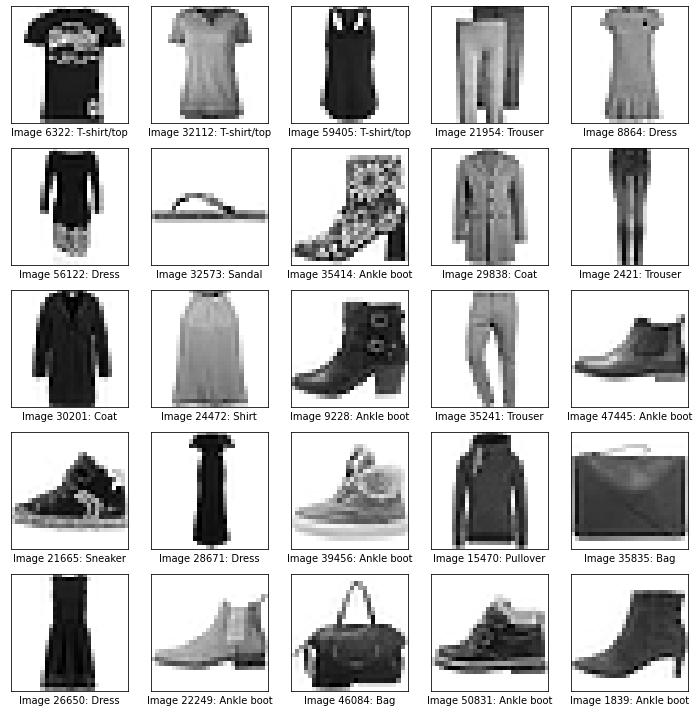

In [8]:
# first 25 images in training 
print('25 Training Images and Labels')
plot_image(trainX, trainY)

25 Test Images and Labels


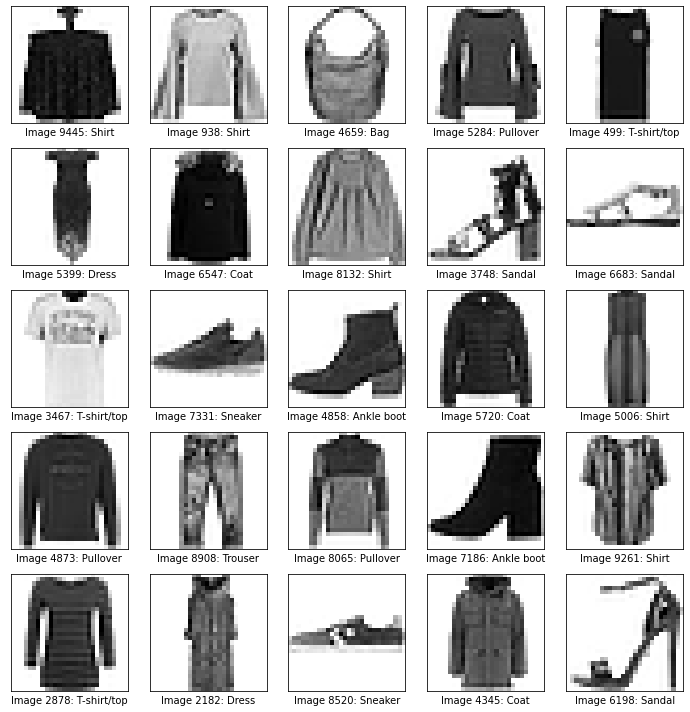

In [9]:
# first 25 images in test set
print('25 Test Images and Labels')
plot_image(testX, testY)

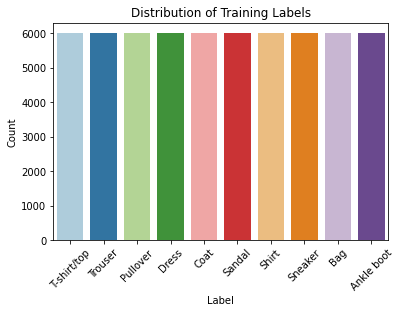

In [68]:
## Distribution of labels
sns.countplot(train_labels, palette = 'Paired')
plt.xticks(np.arange(0,10), labels = class_names, rotation = 45)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Training Labels')
plt.show()

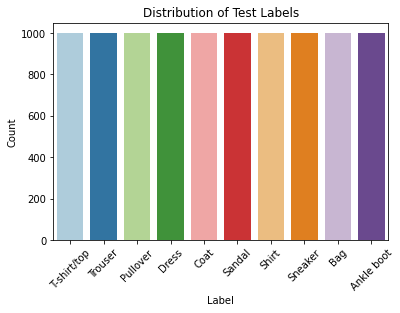

In [69]:
## Distribution of Test Labels
sns.countplot(test_labels, palette = 'Paired')
plt.xticks(np.arange(0,10), labels = class_names, rotation = 45)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Test Labels')
plt.show()

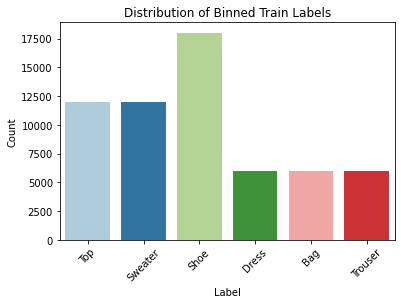

In [70]:
# Distribution of Binned Train Labels
sns.countplot(bin_train_labels, palette = 'Paired')
plt.xticks(np.arange(0,6), labels = bin_class_names, rotation = 45)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Binned Train Labels')
plt.show()

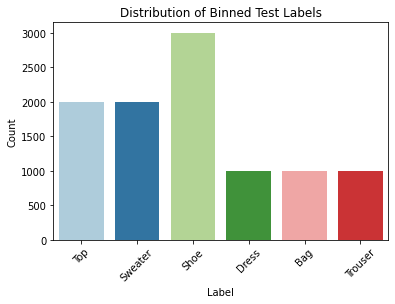

In [71]:
# Distribution of Binned Test Labels
sns.countplot(bin_test_labels, palette = 'Paired')
plt.xticks(np.arange(0,6), labels = bin_class_names, rotation = 45)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Binned Test Labels')
plt.show()

# Evaluation Metrics

## Confusion Matrix and Evaluation

In [0]:
def plot_CM(cm, # confusion_matrix object
            classes, # class labels
            normalize = False, # normalize values
            title = 'Confusion Matrix',
            cmap = 'PuBu'):
  '''
  ouputs: confusion matrix of predicted vs actual labels
  '''
  plt.figure(figsize = (7, 7))
  # plot confusion matrix
  plt.imshow(cm, interpolation = 'nearest', cmap = cmap) 
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 90)
  plt.yticks(tick_marks, classes)
  # normalize the values (%)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    cm = np.round(cm, 2)
  # set threshold for text color
  # if count < half max - white, > half max - black
  thresh = cm.max()/2
  # annotate confusion matrix
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment = 'center',
             color = 'white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')


## Predictions
 - Print Confusion Matrix
 - Print Evaluation Metrics
  - Precision
  - Recall
  - Accuracy
  - F1

In [0]:
def prediction(clf, test, test_labels, title, class_names, normalization = False):
  '''
  this requires the plot_CM function and classification_report to be defined
  input: clf = classifier
  test, test_labels
  title = title of confusion matrix
  normalization = normalize the values of confusion matrix
  class_names = list of item names - either class_names for all 10 or bin_class_names for binned items
  output: accuracy, time elapsed in seconds, confusion matrix of predictions
  classification report
  '''
  y_pred = clf.predict(test)
  cm = confusion_matrix(test_labels, y_pred)
  plot_CM(cm, classes = class_names, title = title, normalize = normalization)
  print(classification_report(test_labels, y_pred,
                              target_names = class_names))

## Print Incorrect Predictions
   - Gives predicted label and actual label

In [0]:
# get 4 incorrect labels
def wrong_labels(test_labels, pred_labels):
  '''
  input: actual and predicted values
  function: gets the first 6 incorrectly predicted images
  returns: list of incorrect predictions
  '''
  incorrect = []
  for i in range(len(test_labels)):
    if test_labels[i] != pred_labels[i]:
      incorrect.append(i)
    if len(incorrect) == 6:
      break
  return incorrect

In [0]:
# plot 6 incorrect predictions with correct labels
# plots 2 x 3
def print_wrong(incorrect, clothing, test_array, test_labels, pred_labels, binned = False):
  '''
  input: incorrect list, clothing dictionary, test labels = actual labels, prediction labels
  binned = using the binned labels, set to True
  test_array = original testing array
  output: plot of the 6 incorrect predictions
  '''
  if binned:
    j = 1
    for i in range(len(incorrect)):
      wrong = str(bin_clothing[pred_labels[incorrect[i]]])
      true = str(bin_clothing[test_labels[incorrect[i]]])
      plt.figure(figsize = (6, 6))
      # location of the plot
      plt.subplot(2,3,j)
      # plot images in black/white
      plt.imshow(test_array[incorrect[i]], cmap = 'gray')
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.title('Predicted Label: {}\nAcual Label: {}'.format(wrong, true))
      plt.tight_layout()
      plt.show()
      # iterate through the location of each subplot
      j += 1
  else:
    j = 1
    for i in range(len(incorrect)):
      wrong = str(clothing[pred_labels[incorrect[i]]])
      true = str(clothing[test_labels[incorrect[i]]])
      plt.figure(figsize = (6, 6))
      # location of the plot
      plt.subplot(2,3,j)
      # plot images in black/white
      plt.imshow(test_array[incorrect[i]], cmap = 'gray')
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.title('Predicted Label: {}\nAcual Label: {}'.format(wrong, true))
      plt.tight_layout()
      plt.show()
      # iterate through the location of each subplot
      j += 1
  

# Linear Regression - SGD Classifier

In [0]:
# use the preprocess dataframes
def lin_reg(train, test, train_labels, test_labels):
  '''
  input: train df and test df, training labels and testing labels
  output: accuracy and time elapsed (sec)
  returns: classifier
  '''  
  print(' -------------- STOCHASTIC GRADIENT DESCENT MODEL ----------------')
  t0 = time.time()
  # create the model
  clf = linear_model.SGDClassifier(penalty = 'l1', random_state = 19)
  # fit the model
  clf.fit(train, train_labels)
  # get accuracy
  #acc = round(clf.score(test, test_labels), 3)
  #print('Accuracy:', acc)
  t1 = time.time()
  # get time taken
  print('Train Time Elapsed (sec): ', round(t1 - t0, 3))
  return clf

## Evaluation on All Items

 -------------- STOCHASTIC GRADIENT DESCENT MODEL ----------------
Train Time Elapsed (sec):  165.936

              precision    recall  f1-score   support

 T-shirt/top       0.70      0.87      0.78      1000
     Trouser       0.96      0.96      0.96      1000
    Pullover       0.79      0.65      0.71      1000
       Dress       0.82      0.84      0.83      1000
        Coat       0.68      0.81      0.74      1000
      Sandal       0.94      0.91      0.92      1000
       Shirt       0.59      0.46      0.52      1000
     Sneaker       0.92      0.90      0.91      1000
         Bag       0.92      0.92      0.92      1000
  Ankle boot       0.95      0.93      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.83      0.83      0.82     10000

Test Time Elapsed (sec): 0.251


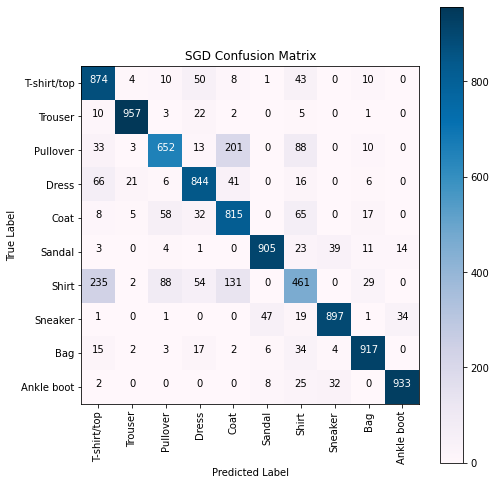

In [22]:
# fit the model
clf = lin_reg(traindf, testdf, train_labels, test_labels)
# get accuracy
sgd_acc = round(clf.score(testdf, test_labels),4)
print()
t0 = time.time()
# evaluate model on test set
prediction(clf, testdf, test_labels, 'SGD Confusion Matrix', class_names, False)
t1 = time.time()
print('Test Time Elapsed (sec): {}'.format(round(t1 - t0, 3)))

### Visualization of Errors

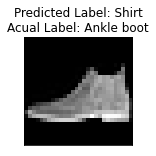

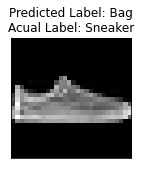

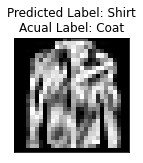

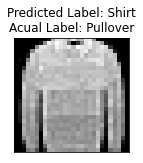

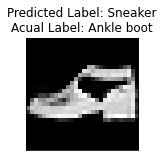

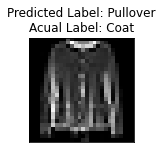

In [23]:
# predictions
sgd_pred = clf.predict(testdf)
# get first 6 incorrect predictions
incorrect = wrong_labels(test_labels, sgd_pred)
# print images and labels
print_wrong(incorrect, clothing, testX, test_labels, sgd_pred)

## Evaluation of Binned Items

In [77]:
print(sgd_acc)
print(sgd_bin_acc)


array([2, 1, 5, 0, 3, 4])

 -------------- STOCHASTIC GRADIENT DESCENT MODEL ----------------
Train Time Elapsed (sec):  103.291

              precision    recall  f1-score   support

         Top       0.85      0.74      0.79      2000
     Sweater       0.80      0.90      0.85      2000
        Shoe       1.00      1.00      1.00      3000
       Dress       0.81      0.84      0.83      1000
         Bag       0.93      0.91      0.92      1000
     Trouser       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.90      0.90      0.90     10000

Test Time Elapsed (sec): 0.201


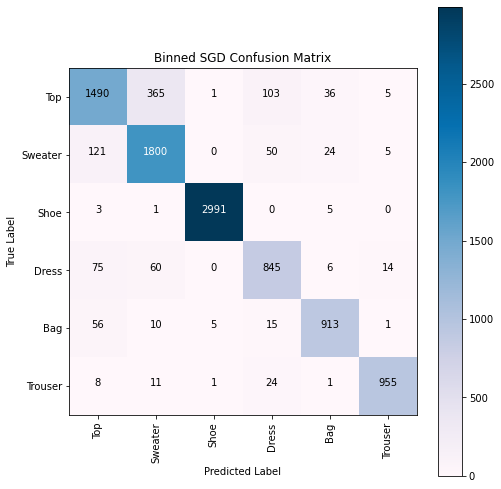

In [78]:
# fit the model
clf = lin_reg(traindf, testdf, bin_train_labels, bin_test_labels)
# get accuracy
sgd_bin_acc = round(clf.score(testdf, bin_test_labels),4)
print()
t0 = time.time()
# evaluate model on test set
prediction(clf, testdf, bin_test_labels, 'Binned SGD Confusion Matrix', bin_class_names, False)
t1 = time.time()
print('Test Time Elapsed (sec): {}'.format(round(t1 - t0, 3)))

### Visualization of Errors

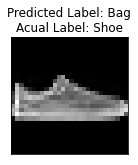

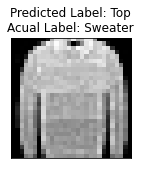

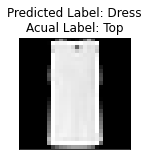

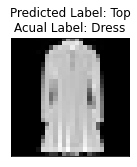

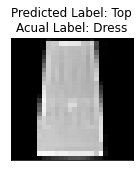

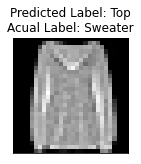

In [79]:
# predictions
sgd_bin_pred = clf.predict(testdf)
# get first 6 incorrect predictions
incorrect = wrong_labels(bin_test_labels, sgd_bin_pred)
# print images and labels
print_wrong(incorrect, bin_clothing, testX, bin_test_labels, sgd_bin_pred, binned = True)

#Multinomial Naive Bayes

In [0]:
def multi_nb(train, train_labels, test, test_labels):
  '''
  - input train df and test df, training labels and testing labels
  - expected output (accuracy and time elapsed (sec)) for each model
  returns: classifier
  ''' 
  print('\n -------------- MULTINOMIAL NAIVE BAYES MODEL ----------------')
  nb_start_time = time.time()
  # store accuracy
  nb_acc_list = []
  # instantiate model
  mnb = MultinomialNB() 
  # fit the model
  mnb.fit(train, train_labels)
  #acc = round(clf.score(test, test_labels), 3)
  #print('Accuracy: {}'.format(acc))
  nb_end_time = time.time()
  print('Train Time Elapsed: {} sec'.format(round(nb_end_time - nb_start_time,2)))
  return mnb
  

## Evaluation


 -------------- MULTINOMIAL NAIVE BAYES MODEL ----------------
Train Time Elapsed: 0.25 sec
              precision    recall  f1-score   support

 T-shirt/top       0.73      0.78      0.75      1000
     Trouser       0.99      0.87      0.93      1000
    Pullover       0.60      0.57      0.58      1000
       Dress       0.66      0.88      0.75      1000
        Coat       0.44      0.60      0.51      1000
      Sandal       0.66      0.14      0.23      1000
       Shirt       0.32      0.16      0.21      1000
     Sneaker       0.60      0.92      0.72      1000
         Bag       0.87      0.80      0.83      1000
  Ankle boot       0.68      0.84      0.75      1000

    accuracy                           0.66     10000
   macro avg       0.65      0.66      0.63     10000
weighted avg       0.65      0.66      0.63     10000

Test Time Elapsed (sec): 0.26


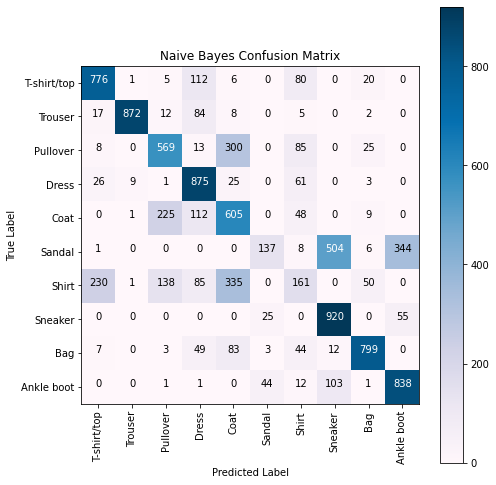

In [27]:
# fit model 
mnb = multi_nb(traindf, train_labels, testdf, test_labels)
# store accuracy
mnb_acc = round(mnb.score(testdf, test_labels), 3)
t0 = time.time()
# evaluate model on test set
prediction(mnb, testdf, test_labels, 'Naive Bayes Confusion Matrix', class_names)
t1 = time.time()
print('Test Time Elapsed (sec): {}'.format(round(t1 - t0, 3)))

### Visualization of Errors

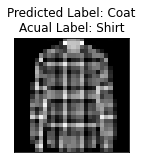

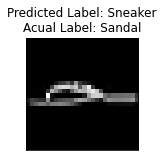

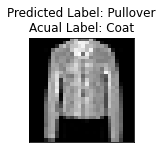

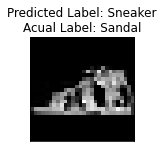

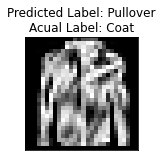

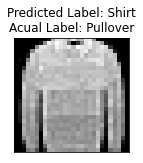

In [28]:
# predictions
nb_pred = mnb.predict(testdf)
# get first 6 incorrect predictions
incorrect = wrong_labels(test_labels, nb_pred)
# print images and labels
print_wrong(incorrect, clothing, testX, test_labels, nb_pred)

## Evaluation on Binned Items


 -------------- MULTINOMIAL NAIVE BAYES MODEL ----------------
Train Time Elapsed: 0.25 sec
              precision    recall  f1-score   support

         Top       0.78      0.56      0.66      2000
     Sweater       0.72      0.85      0.78      2000
        Shoe       1.00      0.97      0.98      3000
       Dress       0.64      0.87      0.74      1000
         Bag       0.83      0.86      0.85      1000
     Trouser       0.99      0.87      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.85      0.83      0.83     10000

Test Time Elapsed (sec): 0.2


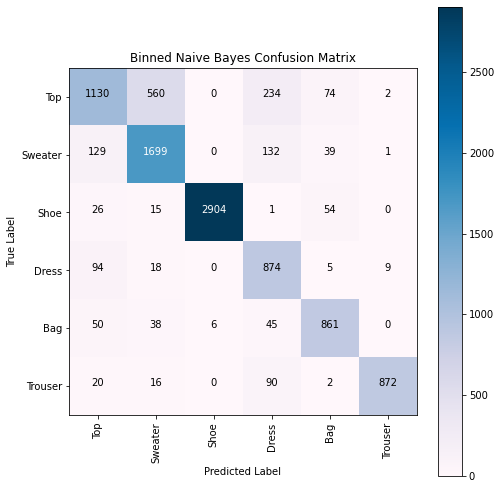

In [80]:
# fit model 
mnb_bin = multi_nb(traindf, bin_train_labels, testdf, bin_test_labels)
# store accuracy
mnb_bin_acc = round(mnb_bin.score(testdf, bin_test_labels), 3)
t0 = time.time()
# evaluate model on test set
prediction(mnb_bin, testdf, bin_test_labels, 'Binned Naive Bayes Confusion Matrix', bin_class_names)
t1 = time.time()
print('Test Time Elapsed (sec): {}'.format(round(t1 - t0, 3)))

### Visualization of Errors

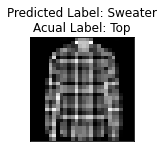

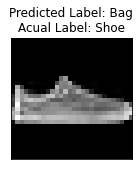

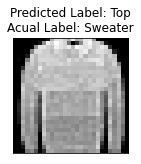

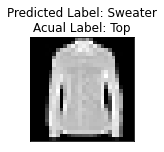

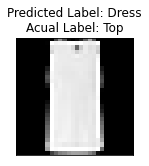

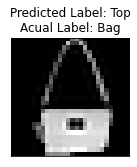

In [81]:
# predictions
nb_bin_pred = mnb_bin.predict(testdf)
# get first 6 incorrect predictions
incorrect = wrong_labels(bin_test_labels, nb_bin_pred)
# print images and labels
print_wrong(incorrect, bin_clothing, testX, bin_test_labels, nb_bin_pred, binned = True)

# Random Forest

In [0]:
def random_forest(train, train_labels, test, test_labels):
  '''
  input: train df and test df, training labels and testing labels
  output: accuracy and time elapsed (sec)
  returns: classifier
  '''
  # store accuracy
  print('\n -------------- RANDOM FOREST MODEL ----------------')
  rfstart_time = time.time()
  # store accuracy  
  forest = RandomForestClassifier(n_estimators = 700)
  forest.fit(train, train_labels)
  acc = round(forest.score(test, test_labels), 3)
  print('Accuracy: ', acc)
  rfend_time = time.time()
  print('Total Random Forest time: {} min'.format(round((rfend_time - rfstart_time)/60, 2)))
  return forest

## Evaluation


 -------------- RANDOM FOREST MODEL ----------------
Accuracy:  0.878
Total Random Forest time: 11.45 min
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.85      0.84      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.78      0.80      0.79      1000
       Dress       0.88      0.91      0.89      1000
        Coat       0.77      0.83      0.80      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.71      0.60      0.65      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Test Time Elapsed (sec): 3.756


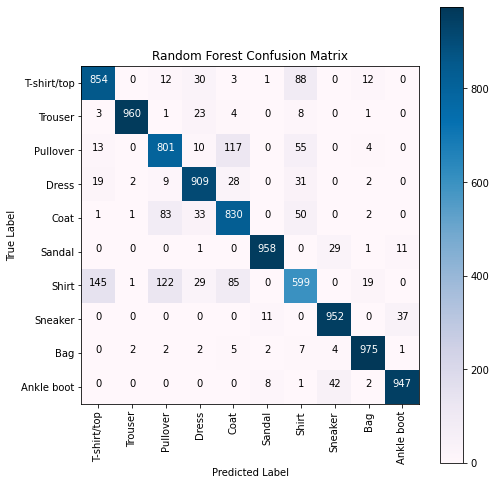

In [47]:
# fit the model
forest = random_forest(traindf, train_labels, testdf, test_labels)
# store accuracy
rf_acc = round(forest.score(testdf, test_labels),4)
t0 = time.time()
# evaluate model on test set
prediction(forest, testdf, test_labels, 'Random Forest Confusion Matrix', class_names)
t1 = time.time()
print('Test Time Elapsed (sec): {}'.format(round(t1 - t0, 3)))

### Visualization of Errors

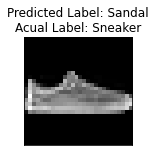

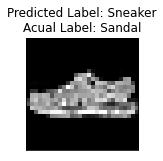

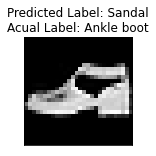

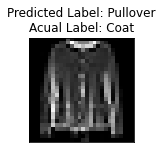

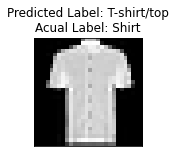

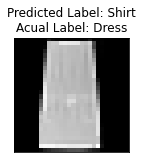

In [49]:
# predictions
rf_pred = forest.predict(testdf)
# get first 6 incorrect labels
incorrect = wrong_labels(test_labels, rf_pred)
# print images and labels
print_wrong(incorrect, clothing, testX, test_labels, rf_pred)

## Evaluation of Binned Items


 -------------- RANDOM FOREST MODEL ----------------
Accuracy:  0.937
Total Random Forest time: 11.44 min
              precision    recall  f1-score   support

         Top       0.90      0.85      0.88      2000
     Sweater       0.86      0.93      0.90      2000
        Shoe       1.00      1.00      1.00      3000
       Dress       0.90      0.88      0.89      1000
         Bag       0.97      0.97      0.97      1000
     Trouser       0.99      0.96      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.94      0.94     10000

Test Time Elapsed (sec): 3.084


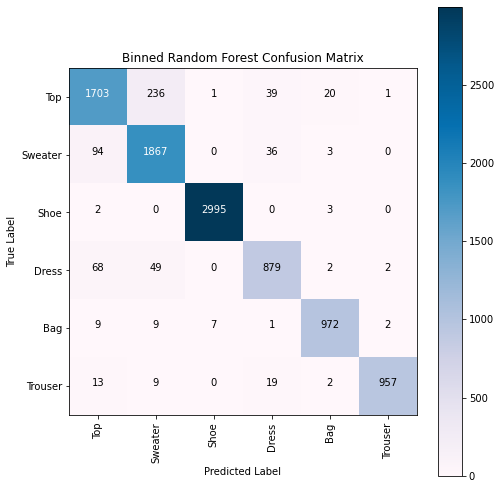

In [138]:
# fit the model
forest_bin = random_forest(traindf, bin_train_labels, testdf, bin_test_labels)
# store accuracy
rf_bin_acc = round(forest_bin.score(testdf, bin_test_labels),4)
t0 = time.time()
# evaluate model on test set
prediction(forest_bin, testdf, bin_test_labels, 'Binned Random Forest Confusion Matrix', bin_class_names)
t1 = time.time()
print('Test Time Elapsed (sec): {}'.format(round(t1 - t0, 3)))

### Visualization of Errors

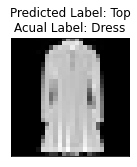

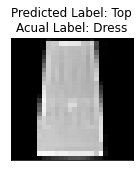

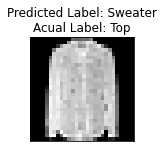

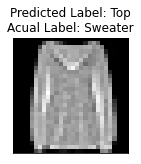

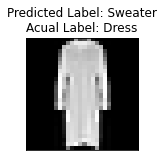

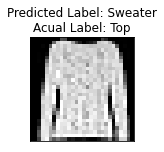

In [86]:
# predictions
rf_bin_pred = forest_bin.predict(testdf)
# get first 6 incorrect labels
incorrect = wrong_labels(bin_test_labels, rf_bin_pred)
#for i in range(len(incorrect)):
 # print(i, incorrect[i])
# print images and labels
print_wrong(incorrect, bin_clothing, testX, bin_test_labels, rf_bin_pred, binned = True)

# Convolutional Neural Network Model

## Validation and Loss Curves

In [0]:
# plot train curve function
def plot_train_curve(history):
    # get training accuracy
    accuracy = history.history['accuracy']
    # get test accuracy
    val_accuracy = history.history['val_accuracy']
    # train loss
    loss = history.history['loss']
    # test los
    val_loss = history.history['val_loss']
    # enumerate each epoch 0 to number of ephochs 
    epochs = range(len(accuracy))
    # use ggplot style from R
    with plt.style.context("ggplot"):
        plt.figure(figsize = (8, 8/1.618))
        # training accuracy line plot
        plt.plot(epochs, accuracy, marker = 'o', c = 'tab:orange', label = 'Training accuracy')
        # test accuracy line plot
        plt.plot(epochs, val_accuracy, marker = 'D', c = 'tab:blue', label = 'Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.xlim(0, epochs)
        plt.legend()
        plt.figure(figsize = (8, 8/1.618))
        # training loss line plot
        plt.plot(epochs, loss, marker = 'o', c = 'tab:orange', label = 'Training loss')
        # test loss line plot
        plt.plot(epochs, val_loss, marker = 'D', c = 'tab:blue', label = 'Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.xlim(0, epochs)
        plt.legend()
        plt.show()

## CNN Model

Steps to Make a CNN
1. Convolution 
* normalize after convolution
2. Activation
* do steps 1 and 2 twice
3. Pooling
* repeat steps 1 - 3 for more layers
4. Fully Connected Network


In [0]:
def cnn_model():
  '''
  creates a neural network model with 2 or 3 layers
  default is 2 layers
  '''
  model = Sequential()
  #1. Convolution layer 1 - activation function = relu
  model.add(Conv2D(filters = 32, 
                   kernel_size = (3,3),
                   activation = 'relu', 
                   padding = 'same', 
                   input_shape = (28, 28, 1)))
  # normalize 
  model.add(BatchNormalization(axis = -1))
 
  # Convolution layer 2 - activation = relu
  model.add(Conv2D(filters = 32, 
                   kernel_size = (3,3),
                   activation = 'relu', 
                   padding = 'same'))
  # normalize
  model.add(BatchNormalization(axis = -1))
  # Dropout to avoid overfitting
  model.add(Dropout(0.25))
  
  # Convolution layer 3 - activation = relu
  model.add(Conv2D(filters = 64,
                   kernel_size = (3,3),
                   activation = 'relu', 
                   padding = 'same'))
  # pooling to reduce dimensionality
  model.add(MaxPooling2D(pool_size = (2,2)))
  # dropout to avoid overfitting
  model.add(Dropout(0.25))
  
  # convolutions layer 4 - activation = relu
  model.add(Conv2D(filters = 128,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'same'))
  model.add(BatchNormalization(axis = -1))
  model.add(Dropout(0.25))
  
  # flatten the data so it can be an input for Dense
  model.add(Flatten())
  model.add(Dense(512, activation = 'relu'))
  model.add(BatchNormalization(axis = -1))
  # reduce overfitting with dropout (50%)
  model.add(Dropout(0.5))
  model.add(Dense(128, activation = 'relu'))
  model.add(BatchNormalization(axis = -1))
  model.add(Dropout(0.5))
  # output - parameter = number of classes (10)
  # activation with softmax - get probs for each class - output = max(prob)
  model.add(Dense(10, activation = 'softmax'))
  
  return model

### Compile the Model to Run

In [0]:
# compile the model
model = cnn_model()
model.compile(optimizer = Adam(lr = 0.001,
                               beta_1 = 0.9,
                               beta_2 = 0.999),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### Learning Rate Decay

Tune learning rate

- too high -> large steps
- too small -> alter weights and biases

In [0]:
reduce_lr = LearningRateScheduler(lambda x: 0.001 * 0.9 **x)

### Augment the Data
Use ImageDataGenerator to randomly move around the image

In [0]:
# data augmentation
# randomly move around the image
datagen = ImageDataGenerator(rotation_range = 8, # randomly rotate images (deg 0 to 180)
                             zoom_range = 0.1, # randomly zoom image
                             shear_range = 0.3, # shear angle in counter-clockwise direction in deg
                             width_shift_range = 0.08, # randomly shift images horizontally (fraction of width)
                             height_shift_range = 0.08, # randomly shift images vertically (fraction of height)
                             vertical_flip = True) # randomly flip images

In [0]:
# fit the generator to the train data
datagen.fit(train_cnn)

### Fit the Model

In [94]:
# fit the model
history = model.fit_generator(datagen.flow(train_cnn, train_cnn_labels, batch_size = 64),
                              epochs = 20,
                              validation_data = (test_cnn, test_cnn_labels),
                              verbose = 2,
                              steps_per_epoch = train_cnn.shape[0]//64,
                              callbacks = [reduce_lr]) # get new learning rate each stage

Epoch 1/20
 - 710s - loss: 0.7994 - accuracy: 0.7141 - val_loss: 0.4754 - val_accuracy: 0.8270
Epoch 2/20
 - 709s - loss: 0.5354 - accuracy: 0.8055 - val_loss: 0.4093 - val_accuracy: 0.8395
Epoch 3/20
 - 710s - loss: 0.4582 - accuracy: 0.8338 - val_loss: 0.3107 - val_accuracy: 0.8896
Epoch 4/20
 - 694s - loss: 0.4209 - accuracy: 0.8493 - val_loss: 0.3149 - val_accuracy: 0.8865
Epoch 5/20
 - 706s - loss: 0.3886 - accuracy: 0.8614 - val_loss: 0.2994 - val_accuracy: 0.8919
Epoch 6/20
 - 693s - loss: 0.3711 - accuracy: 0.8681 - val_loss: 0.2912 - val_accuracy: 0.8964
Epoch 7/20
 - 692s - loss: 0.3553 - accuracy: 0.8734 - val_loss: 0.2596 - val_accuracy: 0.9060
Epoch 8/20
 - 695s - loss: 0.3416 - accuracy: 0.8766 - val_loss: 0.2448 - val_accuracy: 0.9102
Epoch 9/20
 - 696s - loss: 0.3256 - accuracy: 0.8828 - val_loss: 0.2623 - val_accuracy: 0.9018
Epoch 10/20
 - 694s - loss: 0.3188 - accuracy: 0.8855 - val_loss: 0.2370 - val_accuracy: 0.9132
Epoch 11/20
 - 689s - loss: 0.3089 - accuracy: 0.

In [0]:
# save the model
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

### Evaluation

In [99]:
### EVALUATE MODEL
t0 = time.time()
score = model.evaluate(test_cnn, test_cnn_labels)
# store accuracy
cnn_acc = round(score[1],4)
t1 = time.time()
print('loss: {}'.format(round(score[0],4)))
print('accuracy: {}'.format(round(score[1], 4)))
print('Test Time Elapsed (sec): {}'.format(round(t1 - t0, 3)))

10000/10000 [==============================] - 27s 3ms/step
loss: 0.2031
accuracy: 0.9236
Test Time Elapsed (sec): 27.491


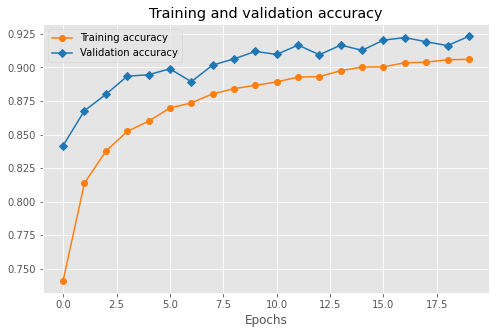

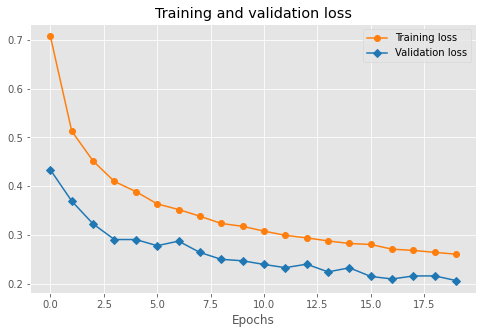

In [58]:
### ACCURACY AND LOSS CURVES
plot_train_curve(history)

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.86      0.87      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.89      0.91      0.90      1000
       Dress       0.92      0.91      0.92      1000
        Coat       0.89      0.88      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.77      0.78      0.78      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



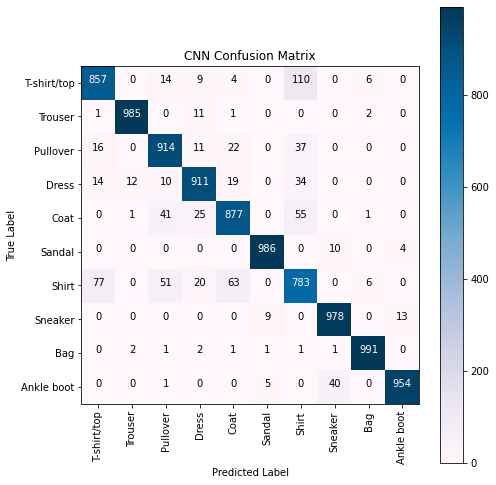

In [102]:
### CONFUSION MATRIX

# predict values from test set
y_pred = model.predict(test_cnn)
# convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# convert test labels to one hot vectors
y_true = np.argmax(test_cnn_labels, axis = 1)
# compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
# plot confusion matrix
plot_CM(cm, class_names, False, 'CNN Confusion Matrix')

print(classification_report(y_true, y_pred_classes,
                            target_names = class_names))

### Visualization of Errors

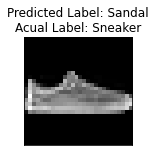

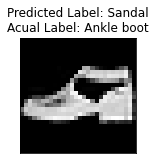

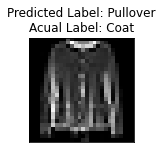

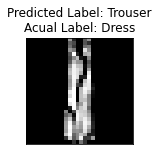

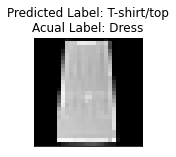

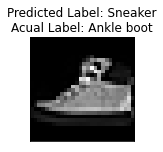

In [103]:
# get first 6 incorrect labels
incorrect = wrong_labels(y_pred_classes, y_true)
# print images and labels
print_wrong(incorrect, clothing, testX, test_labels, y_pred_classes)

## CNN Model for Binned Labels

In [0]:
def bin_cnn_model():
  '''
  creates a neural network model with 2 or 3 layers
  default is 2 layers
  '''
  model = Sequential()
  #1. Convolution layer 1 - activation function = relu
  model.add(Conv2D(filters = 32, 
                   kernel_size = (3,3),
                   activation = 'relu', 
                   padding = 'same', 
                   input_shape = (28, 28, 1)))
  # normalize 
  model.add(BatchNormalization(axis = -1))
 
  # Convolution layer 2 - activation = relu
  model.add(Conv2D(filters = 32, 
                   kernel_size = (3,3),
                   activation = 'relu', 
                   padding = 'same'))
  # normalize
  model.add(BatchNormalization(axis = -1))
  # Dropout to avoid overfitting
  model.add(Dropout(0.25))
  
  # Convolution layer 3 - activation = relu
  model.add(Conv2D(filters = 64,
                   kernel_size = (3,3),
                   activation = 'relu', 
                   padding = 'same'))
  # pooling to reduce dimensionality
  model.add(MaxPooling2D(pool_size = (2,2)))
  # dropout to avoid overfitting
  model.add(Dropout(0.25))
  
  # convolutions layer 4 - activation = relu
  model.add(Conv2D(filters = 128,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'same'))
  model.add(BatchNormalization(axis = -1))
  model.add(Dropout(0.25))
  
  # flatten the data so it can be an input for Dense
  model.add(Flatten())
  model.add(Dense(512, activation = 'relu'))
  model.add(BatchNormalization(axis = -1))
  # reduce overfitting with dropout (50%)
  model.add(Dropout(0.5))
  model.add(Dense(128, activation = 'relu'))
  model.add(BatchNormalization(axis = -1))
  model.add(Dropout(0.5))
  # output - parameter = number of classes (6)
  # activation with softmax - get probs for each class - output = max(prob)
  model.add(Dense(6, activation = 'softmax'))
  
  return model

### Compile the Model

In [0]:
# compile the model
bin_model = bin_cnn_model()
bin_model.compile(optimizer = Adam(lr = 0.001,
                               beta_1 = 0.9,
                               beta_2 = 0.999),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### Fit The Model

In [118]:
# fit the model
bin_history = bin_model.fit_generator(datagen.flow(train_cnn, bin_train_cnn_labels, batch_size = 64),
                              epochs = 20,
                              validation_data = (test_cnn, bin_test_cnn_labels),
                              verbose = 2,
                              steps_per_epoch = train_cnn.shape[0]//64,
                              callbacks = [reduce_lr]) # get new learning rate each stage

Epoch 1/20
 - 699s - loss: 0.4514 - accuracy: 0.8287 - val_loss: 0.2714 - val_accuracy: 0.8954
Epoch 2/20
 - 697s - loss: 0.3162 - accuracy: 0.8780 - val_loss: 0.2182 - val_accuracy: 0.9178
Epoch 3/20
 - 694s - loss: 0.2742 - accuracy: 0.8982 - val_loss: 0.2047 - val_accuracy: 0.9195
Epoch 4/20
 - 694s - loss: 0.2491 - accuracy: 0.9063 - val_loss: 0.1808 - val_accuracy: 0.9347
Epoch 5/20
 - 701s - loss: 0.2357 - accuracy: 0.9132 - val_loss: 0.1802 - val_accuracy: 0.9327
Epoch 6/20
 - 700s - loss: 0.2180 - accuracy: 0.9189 - val_loss: 0.1806 - val_accuracy: 0.9327
Epoch 7/20
 - 695s - loss: 0.2072 - accuracy: 0.9232 - val_loss: 0.2161 - val_accuracy: 0.9247
Epoch 8/20
 - 689s - loss: 0.2006 - accuracy: 0.9252 - val_loss: 0.1584 - val_accuracy: 0.9423
Epoch 9/20
 - 691s - loss: 0.1904 - accuracy: 0.9293 - val_loss: 0.1441 - val_accuracy: 0.9456
Epoch 10/20
 - 687s - loss: 0.1842 - accuracy: 0.9323 - val_loss: 0.1421 - val_accuracy: 0.9487
Epoch 11/20
 - 689s - loss: 0.1776 - accuracy: 0.

In [14]:
# save the model
bin_model.save('my_bin_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model
# returns a compiled model
# identical to the previous one
bin_model = load_model('my_bin_model.h5')

OSError: ignored

### Evaluation of Binned Items

In [123]:
### EVALUATE MODEL
t0 = time.time()
bin_score = bin_model.evaluate(test_cnn, bin_test_cnn_labels)
# store accuracy
cnn_bin_acc = round(bin_score[1],4)
t1 = time.time()
print('loss: {}'.format(round(bin_score[0],4)))
print('accuracy: {}'.format(round(bin_score[1], 4)))
print('Test Time Elapsed (sec): {}'.format(round(t1 - t0, 3)))

10000/10000 [==============================] - 27s 3ms/step
loss: 0.1318
accuracy: 0.9504
Test Time Elapsed (sec): 27.092


              precision    recall  f1-score   support

         Top       0.86      0.95      0.90      2000
     Sweater       0.95      0.86      0.90      2000
        Shoe       1.00      1.00      1.00      3000
       Dress       0.93      0.91      0.92      1000
         Bag       0.99      0.99      0.99      1000
     Trouser       0.99      0.98      0.99      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



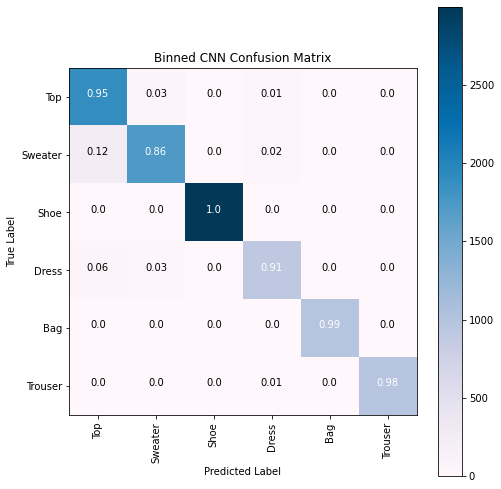

In [130]:
### CONFUSION MATRIX
#plot_CM(cm, # confusion_matrix object
 #           classes, # class labels
  #          normalize = False, # normalize values
   #         title = 'Confusion Matrix',
    #        cmap = 'PuBu')
# predict values from test set
y_bin_pred = bin_model.predict(test_cnn)
# convert predictions classes to one hot vectors
y_bin_pred_classes = np.argmax(y_bin_pred, axis = 1)
# convert test labels to one hot vectors
y_bin_true = np.argmax(bin_test_cnn_labels, axis = 1)
# compute confusion matrix
cm = confusion_matrix(y_bin_true, y_bin_pred_classes)
# plot confusion matrix
plot_CM(cm = cm, 
        classes = bin_class_names,
        normalize = True,
        title = 'Binned CNN Confusion Matrix')
print(classification_report(y_bin_true, y_bin_pred_classes,
                            target_names = bin_class_names))

array([2, 1, 5, ..., 4, 5, 2])

              precision    recall  f1-score   support

         Top       0.86      0.95      0.90      2000
     Sweater       0.95      0.86      0.90      2000
        Shoe       1.00      1.00      1.00      3000
       Dress       0.93      0.91      0.92      1000
         Bag       0.99      0.99      0.99      1000
     Trouser       0.99      0.98      0.99      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



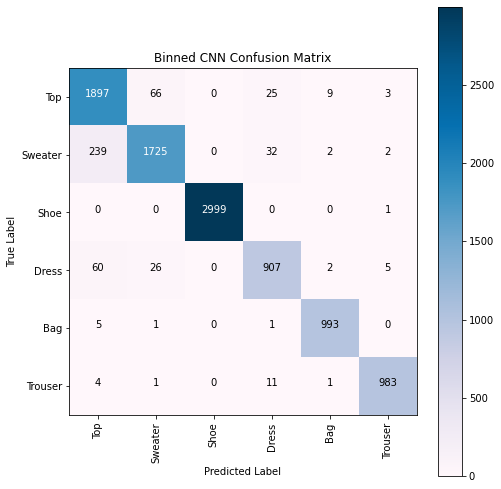

In [133]:
### CONFUSION MATRIX
#plot_CM(cm, # confusion_matrix object
 #           classes, # class labels
  #          normalize = False, # normalize values
   #         title = 'Confusion Matrix',
    #        cmap = 'PuBu')
# predict values from test set
y_bin_pred = bin_model.predict(test_cnn)
# convert predictions classes to one hot vectors
y_bin_pred_classes = np.argmax(y_bin_pred, axis = 1)
# convert test labels to one hot vectors
y_bin_true = np.argmax(bin_test_cnn_labels, axis = 1)
# compute confusion matrix
cm = confusion_matrix(y_bin_true, y_bin_pred_classes)
# plot confusion matrix
plot_CM(cm = cm, 
        classes = bin_class_names,
        normalize = False,
        title = 'Binned CNN Confusion Matrix')
print(classification_report(y_bin_true, y_bin_pred_classes,
                            target_names = bin_class_names))

### Visualization of Errors

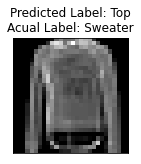

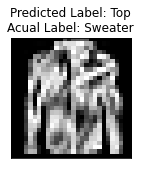

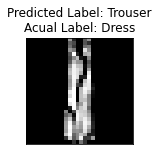

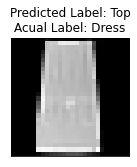

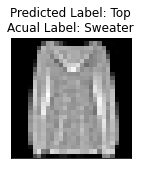

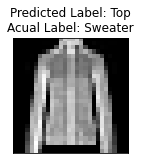

In [135]:
# get first 6 incorrect labels
incorrect = wrong_labels(y_bin_pred_classes, y_bin_true)
# print images and labels
print_wrong(incorrect, bin_clothing, testX, bin_test_labels, y_bin_pred_classes)

# Comparison of Models

## Accuracy

In [177]:
# list of models
models = ['SGD', 'MNB', 'RF', 'CNN']
# list of model accuracies
acc_list = [sgd_acc, mnb_acc, rf_acc, cnn_acc]
bin_acc_list = [sgd_bin_acc, mnb_bin_acc, rf_bin_acc, cnn_bin_acc]
acc_plot = []
for acc in acc_list:
  new_acc = round(acc * 100, 2)
  acc_plot.append(str(new_acc) + '%')
bin_acc_plot = []
for acc in bin_acc_list:
  new_acc = round(acc * 100, 2)
  bin_acc_plot.append(str(new_acc) + '%')
# create a dataframe for accuracy
acc_df = pd.DataFrame(zip(models, acc_list, acc_plot, bin_acc_list, bin_acc_plot), 
                      columns = ['model', 'All Labels', 'lab acc', 'Binned Labels', 'bin plot acc'])
acc_df = acc_df.sort_values(by = 'All Labels', ascending = False)
acc_df.index = np.arange(0,4)
acc_df

,model,All Labels,lab acc,Binned Labels,bin plot acc
0,CNN,0.9236,92.36%,0.9504,95.04%
1,RF,0.8785,87.85%,0.9373,93.73%
2,SGD,0.8255,82.55%,0.8994,89.94%
3,MNB,0.6550,65.5%,0.8340,83.4%


In [179]:
acc_plot_df = acc_df[['model', 'All Labels', 'Binned Labels']].melt(id_vars = 'model', var_name = 'Labels', value_name = 'Accuracy')
acc_plot_df

,model,Labels,Accuracy
0,CNN,All Labels,0.9236
1,RF,All Labels,0.8785
2,SGD,All Labels,0.8255
3,MNB,All Labels,0.6550
4,CNN,Binned Labels,0.9504
5,RF,Binned Labels,0.9373
6,SGD,Binned Labels,0.8994
7,MNB,Binned Labels,0.8340


## Plot Comparisons

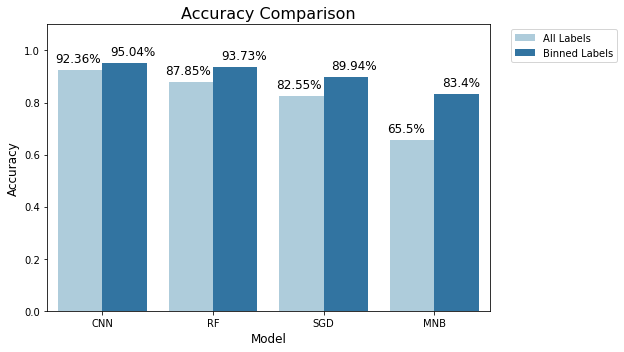

In [196]:
## barplot of accuracy comparisons between models and label binning
plt.figure(figsize = (7,5))
sns.barplot(x = 'model', y = 'Accuracy', hue = 'Labels', data = acc_plot_df, palette = 'Paired')
plt.title('Accuracy Comparison', size = 16)
plt.xlabel('Model', size = 12)
plt.ylabel('Accuracy', size = 12)
#for i in np.arange(0,4):
 # plt.text(x = i - 0.45, 
  #         y = acc_df['Accuracy'][i] + 0.01,
   #        s = acc_df['lab acc'][i],
    #       size = 12)
for i in range(len(acc_df)):
  # print percentages of binned labels
  plt.text(x = i + 0.07, 
             y = acc_df['Binned Labels'][i] + 0.03, 
             s = str(acc_df['bin plot acc'][i]),
             size = 12)
  # print percentages of all labels
  plt.text(x = i - 0.43, 
             y = acc_df['All Labels'][i] + 0.03, 
             s = str(acc_df['lab acc'][i]),
             size = 12)
plt.tight_layout()
plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()

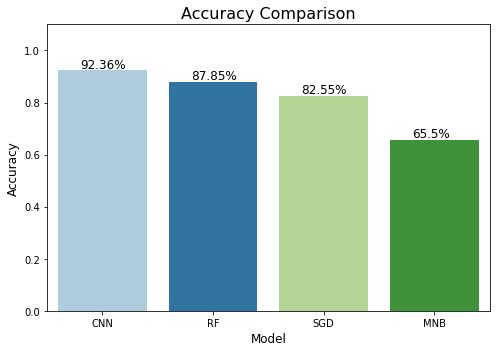

In [217]:
### bar plot of accuracy comparisons
plt.figure(figsize = (7,5))
sns.barplot(x = 'model', y = 'All Labels', data = acc_df, palette = 'Paired')
plt.title('Accuracy Comparison', size = 16)
plt.xlabel('Model', size = 12)
plt.ylabel('Accuracy', size = 12)
for i in np.arange(0,4):
  plt.text(x = i - 0.2, 
           y = acc_df['All Labels'][i] + 0.01,
           s = acc_df['lab acc'][i],
           size = 12)
plt.tight_layout()
plt.ylim(0,1.1)
plt.show()

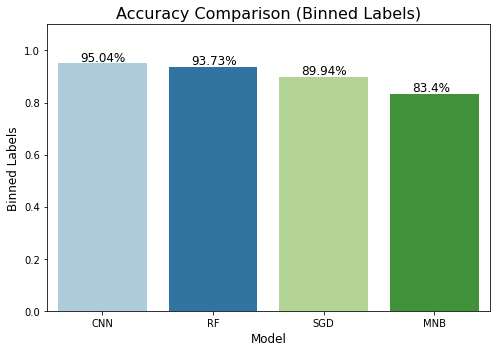

In [218]:
### bar plot of accuracy comparisons
plt.figure(figsize = (7,5))
sns.barplot(x = 'model', y = 'Binned Labels', data = acc_df, palette = 'Paired')
plt.title('Accuracy Comparison (Binned Labels)', size = 16)
plt.xlabel('Model', size = 12)
plt.ylabel('Binned Labels', size = 12)
for i in np.arange(0,4):
  plt.text(x = i - 0.2, 
           y = acc_df['Binned Labels'][i] + 0.01,
           s = acc_df['bin plot acc'][i],
           size = 12)
plt.tight_layout()
plt.ylim(0,1.1)
plt.show()

## Compute Time

In [205]:
# list of times for training and evaluating models all labels
train_times = [169.27, 0.28, round(11.14*60,2), 616]
test_times = [0.25, 0.26, 3.84, 22.47]
# create a dataframe
time_df = pd.DataFrame(zip(models, train_times, test_times), columns = ['model', 'Train', 'Test'])
time_df = time_df.sort_values(by = 'Train')
time_df.index = range(len(time_df))
time_df = time_df.melt(id_vars = 'model', var_name = 'Set', value_name = 'time')
time_df

,model,Set,time
0,MNB,Train,0.28
1,SGD,Train,169.27
2,CNN,Train,616.00
3,RF,Train,668.40
4,MNB,Test,0.26
5,SGD,Test,0.25
6,CNN,Test,22.47
7,RF,Test,3.84


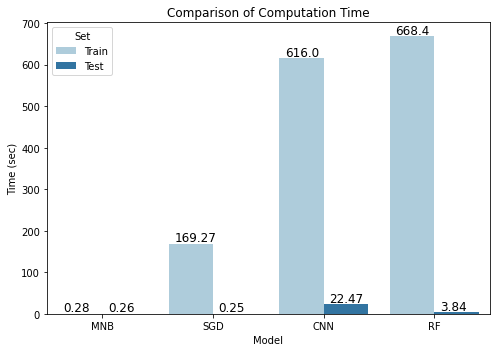

In [199]:
plt.figure(figsize = (7,5))
sns.barplot(x = 'model', y = 'time', hue = 'Set', data = time_df, palette = 'Paired')
plt.title('Comparison of Computation Time')
plt.xlabel('Model')
plt.ylabel('Time (sec)')
j = 4
for i in range(len(time_df)):
  if i >= 4:
    i = i - 4
    plt.text(x = i + 0.05, 
             y = time_df['time'][j] + 5, 
             s = str(time_df['time'][j]),
             size = 12)
    j += 1
  else:
    plt.text(x = i - 0.35, 
             y = time_df['time'][i] + 5, 
             s = str(time_df['time'][i]),
             size = 12)
plt.tight_layout()
plt.show()

In [210]:
# list of times for training and evaluating models binned labels
bin_train_times = [103.29, 0.25, round(11.63*60,2), 684]
bin_test_times = [0.2, 0.2, 2.96, 27.09]
# create a dataframe
bin_time_df = pd.DataFrame(zip(models, bin_train_times, bin_test_times), columns = ['model', 'Train', 'Test'])
bin_time_df = bin_time_df.sort_values(by = 'Train')
bin_time_df.index = range(len(bin_time_df))
bin_time_df = bin_time_df.melt(id_vars = 'model', var_name = 'Set', value_name = 'time')
bin_time_df

,model,Set,time
0,MNB,Train,0.25
1,SGD,Train,103.29
2,CNN,Train,684.00
3,RF,Train,697.80
4,MNB,Test,0.20
5,SGD,Test,0.20
6,CNN,Test,27.09
7,RF,Test,2.96


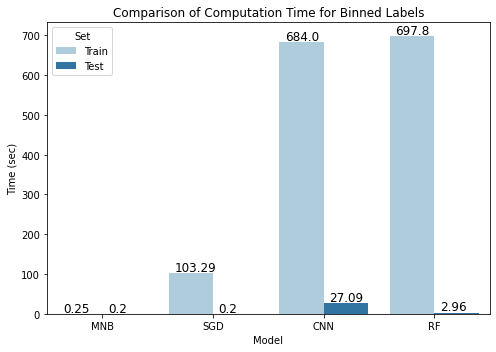

In [211]:
plt.figure(figsize = (7,5))
sns.barplot(x = 'model', y = 'time', hue = 'Set', data = bin_time_df, palette = 'Paired')
plt.title('Comparison of Computation Time for Binned Labels')
plt.xlabel('Model')
plt.ylabel('Time (sec)')
j = 4
for i in range(len(time_df)):
  if i >= 4:
    i = i - 4
    plt.text(x = i + 0.05, 
             y = bin_time_df['time'][j] + 5, 
             s = str(bin_time_df['time'][j]),
             size = 12)
    j += 1
  else:
    plt.text(x = i - 0.35, 
             y = bin_time_df['time'][i] + 5, 
             s = str(bin_time_df['time'][i]),
             size = 12)
plt.tight_layout()
plt.show()

## Final Comparison Dataframe

In [213]:
df = pd.DataFrame(zip(models, acc_plot, bin_acc_plot, train_times, bin_train_times, test_times, bin_test_times),
                  columns = ['Model', 'Accuracy', 'Bin Accuracy', 'Train Time', 'Bin Train Time', 'Test Time', 'Bin Test Time'])
df = df.sort_values(by = 'Accuracy', ascending = False)
df.index = range(len(df))
df

,Model,Accuracy,Bin Accuracy,Train Time,Bin Train Time,Test Time,Bin Test Time
0,CNN,92.36%,95.04%,616.00,684.00,22.47,27.09
1,RF,87.85%,93.73%,668.40,697.80,3.84,2.96
2,SGD,82.55%,89.94%,169.27,103.29,0.25,0.20
3,MNB,65.5%,83.4%,0.28,0.25,0.26,0.20


In [17]:
668/60

11.133333333333333

In [18]:
.13*60

7.800000000000001

# DON'T USE ANYTHING BELOW HERE---

## Confusion Matrix

In [0]:
def plot_CM(cm, 
            classes, 
            normalize = False,
            title = 'Confusion Matrix',
            cmap = plt.cm.RdBu):
  plt.imshow(cm, interpolation = 'nearest', cmap = cmap) # plot confusion matrix
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 90)
  plt.yticks(tick_marks, classes)
  # normalize the values (%)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
  # set threshold for text color
  thresh = cm.max()/2
  # annotate confusion matrix
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment = 'center',
             color = 'white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')


In [0]:
# predict values from test set
y_pred = cnn.predict(test_cnn)
# convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# convert test labels to one hot vectors
y_true = np.argmax(testcnn_labels, axis = 1)
# compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
# plot confusion matrix
plot_CM(cm, classes = class_names)

# Visualization of Predicted Classes

In [0]:
incorrect = []
for i in range(len(testcnn_labels)):
  if not y_pred_classes[i] == y_true[i]:
    incorrect.append(i)
  if len(incorrect) == 4:
    break

In [0]:
# create a dictionary of clothes and labels
clothing = {0: 'T-shirt/top',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle boot'}

In [0]:
# plot 4 misclassified images
fig, ax = plt.subplots(2,2, figsize = (12,6))
fig.set_size_inches(10, 10)
# image 1
ax[0,0].imshow(sub_train_cnn[incorrect[0]].reshape(28,28),
               cmap = 'gray')
incorrect1 = str(clothing[y_pred_classes[incorrect[0]]])
actual1 = str(clothing[y_true[incorrect[0]]])
ax[0,0].set_title('Predicted Label: {}\nActual Label: {}'.format(incorrect1, actual1))
# image 2
ax[0,1].imshow(sub_train_cnn[incorrect[1]].reshape(28,28),
               cmap = 'gray')
incorrect2 = str(clothing[y_pred_classes[incorrect[1]]])
actual2 = str(clothing[y_true[incorrect[1]]])
ax[0,1].set_title('Predicted Label: {}\nActual Label: {}'.format(incorrect2, actual2))
# image 3
ax[1,0].imshow(sub_train_cnn[incorrect[1]].reshape(28,28),
               cmap = 'gray')
incorrect3 = str(clothing[y_pred_classes[incorrect[2]]])
actual3 = str(clothing[y_true[incorrect[2]]])
ax[1,0].set_title('Predicted Label: {}\nActual Label: {}'.format(incorrect3, actual3))
# image 4
ax[1,1].imshow(sub_train_cnn[incorrect[3]].reshape(28,28),
               cmap = 'gray')
incorrect4 = str(clothing[y_pred_classes[incorrect[3]]])
actual4 = str(clothing[y_true[incorrect[3]]])
ax[1,1].set_title('Predicted Label: {}\nActual Label: {}'.format(incorrect4, actual4))

# Classification Report

In [0]:
print(classification_report(y_true,
                            y_pred_classes,
                            target_names = class_names))

In [0]:
def fit_cnn(model, train_cnn, train_cnn_labels,
            test_cnn, test_cnn_labels, batch, epochs):
  '''
  inputs: cnn model, cnn training set, cnn training labels,
  cnn test set, cnn test labels, batch size, number of epochs

  computes: runs the cnn model for learning rates 0.1, 0.01, 0.001

  output: each epoch training/test loss and accuracy
  '''
  #learning_rates = [0.1, 0.01, 0.001]
  #for lr in learning_rates: 
  t1 = time.time()
    # compile the model
  model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.01),
              metrics = ['accuracy'])
    # fit model on train validate on test
  history = model.fit(train_cnn, 
                  train_cnn_labels,
                  batch_size = batch, 
                  epochs = epochs,
                  verbose = 2,
                  validation_data = (test_cnn, test_cnn_labels))
  plot_train_curve(history)
  t2 = time.time() 
  t = round((t2 - t1)/60,2)
  print('Time for learning rate = {}: {} (min)'.format(0.01, t))
  return history


In [0]:
# neural network on subset
start_time = time.time()
cnn = cnn_model()
#sub_train_cnn, sub_test_cnn, sub_traincnn_labels, sub_testcnn_labels
fit_cnn(cnn, sub_train_cnn, sub_traincnn_labels, sub_test_cnn, sub_testcnn_labels, batch = 64, epochs = 10)
#print('CNN Learn Rate = 0.01')
#plot_train_curve(history_2_layers)
end_time = time.time()
total_time = end_time - start_time
print('Total Elapsed Time: {} (hrs)'.format(round(total_time/3600,2)))

In [0]:
# neural network on whole data set
start_time = time.time()
cnn = cnn1_model()
history_2_layers  = fit_cnn(cnn, train_cnn, train_cnn_labels, test_cnn, test_cnn_labels, batch = 64, epochs = 10)
print('CNN Learn Rate = 0.01')
#plot_train_curve(history_2_layers)
end_time = time.time()
total_time = end_time - start_time
print('Total Elapsed Time: {} (hrs)'.format(round(total_time/3600,2)))

In [0]:
model = cnn1_model()
score = model.evaluate(test_cnn, test_cnn_labels)
print('Loss: {}'.format(round(score[0],4))
print('Accuracy: {}'.format(round(score[1],4))

In [0]:
# CNN from https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
# defind cnn model function
def define_cnn_model():
  model = Sequential()
  # add the first convolution layer
  model.add(Conv2D(filters = 32, 
                   kernel_size = (3,3), 
                   padding = 'same', 
                   activation = 'relu', 
                   kernel_initializer = 'he_uniform',
                   input_shape = (28, 28, 1)))
  # add pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))
  # flatten the layer
  model.add(Flatten())
  # add dense layer
  model.add(Dense(100, 
                  activation = 'relu',
                  kernel_initializer = 'he_uniform'))
  # add final dense layer - softmax activation
  model.add(Dense(10,
                  activation = 'softmax'))
  # compile the model - stochastic gradient descent optimizer
  opt = SGD(lr = 0.01,
            momentum = 0.9)
  model.compile(optimizer = opt,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [0]:
# define metrics evaluation for k-fold cv function
def evaluate_model(trainX, trainY, n_folds = 5):
  t0 = time.time()
  # get scores and histories list for storage for each iteration
  scores = []
  histories = []
  # cross validation
  kfold = KFold(n_folds,
                shuffle = True,
                random_state = 19)
  # enumerate the splits
  for train_ix, test_ix in kfold.split(trainX):
    # define the model
    model = define_cnn_model()
    # get the test/train splits for cv
    train_X, train_Y, test_X, test_Y = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix] 
    # fit the model
    history = model.fit(train_X, train_Y, epochs = 10, 
                        batch_size = 32, 
                        validation_data = (test_X, test_Y), 
                        verbose = 0)
    # evaluate the model
    _, acc = model.evaluate(test_X, test_Y, verbose = 0)
    print('accuracy: {}%'.format(round(acc*100, 3)))
    # plot train/test curves
    plot_train_curve(history)
    # store scores and model results
    scores.append(acc)
    histories.append(history)
    t1 = time.time()
    t = round(t1 - t0, 3)
  print('Time elapsed: {}'.format(t))
  return scores, histories

In [0]:
# summarize model performance function
def summarize_performance(scores):
  # print the summary
  avg = round(np.mean(scores)*100,3)
  st_dev = round(np.std(scores)*100,3)
  n = len(scores)
  print('Accuracy: mean = {}%, standard deviation = {},  number of folds = {}'.format(avg, st_dev, n))
  plt.boxplot(scores)
  plt.show()

In [0]:
# aggregate plot of train/validation accuracy
def plot_curves(histories):
  for i in range(len(histories)):
    # plot the loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'],
             color = 'tab:orange', label = 'Training Loss')
    plt.plot(histories[i].history['val_loss'],
             color = 'tab:blue', label = 'Validation Loss')
    # plot the accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'],
             color = 'tab:orange', label = 'Training Accuracy')
    plt.plot(histories[i].history['val_accuracy'], 
             color = 'tab:blue', label = 'Validation Accuracy')
  plt.tight_layout()
  plt.show()

In [0]:
# use subsets sub_train_cnn, sub_traincnn_labels
# train_cnn, test_cnn, train_cnn_labels, test_cnn_labels
scores, histories = evaluate_model(train_cnn, train_cnn_labels)

In [0]:
summarize_performance(scores)

In [0]:
plot_curves(histories)

#### Subsetting data to test models

In [0]:
'''# Sequential model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim = num_pixels, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(10, kernel_initializer = 'normal', activation = 'softmax'))
    # Compile model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
'''

In [0]:
'''model = baseline_model()

# FIT THE MODEL

history  = model.fit(traindf, train_labels, validation_data = (testdf, test_labels), epochs = 300, batch_size = 1000, verbose = 2)

# EVALUATE THE MODEL
scores = model.evaluate(test_clothes, testY, verbose = 0)
print("Baseline Error: %.2f%%" % (100-scores[1] * 100))
'''

In [0]:
'''# parameters to reduce overfitting
# use on train set
gen = ImageDataGenerator(rotation_range = 8,
                         width_shift_range = 0.08, # shift 8% of total width
                         height_shift_range = 0.08, # shift 8% of total height
                         shear_range = 0.3, # shear angle
                         zoom_range = 0.08) # zoom amount
# use on test set
test_gen = ImageDataGenerator()
'''

In [0]:
'''# train the model in batches
train_generator = gen.flow(train_cnn, train_cnn_labels, batch_size = 64)
test_generator = test_gen.flow(test_cnn, test_cnn_labels, batch_size = 64)
'''

In [0]:
'''# fit the model
history = model.fit_generator(train_generator,
                    steps_per_epoch = 60000//64,
                    epochs = 5,
                    validation_data = test_generator,
                    validation_steps = 10000//64)
'''

In [0]:
'''
# subset the data for testing models
def subset(df, n):
  df_list = []
  for i in range(len(df['label'].unique())):
    dfi = df.loc[df['label'] == i][:n]
    df_list.append(dfi)
  final_df = pd.concat(df_list)
  return final_df
'''

In [0]:
'''
# subset the train and test data
train_small_df = trainX.reshape(trainX.shape[0], num_pixels).astype('float32')
test_small_df = testX.reshape(testX.shape[0], num_pixels).astype('float32')
# convert to df
train_small_df = pd.DataFrame(train_small_df)
test_small_df = pd.DataFrame(test_small_df)
# add labels
train_small_df.insert(0, 'label', trainY)
test_small_df.insert(0, 'label', testY)
# get 10% from eachitem - balanced 
train_small = subset(train_small_df, 600)
test_small = subset(test_small_df, 100)
# get the labels
train_labels_small = train_small['label']
test_labels_small = test_small['label']
# drop the labels for models
train_small.drop(['label'], axis = 1, inplace = True)
test_small.drop(['label'], axis = 1, inplace = True)

print('Train subset size: {}'.format(train_small.shape))
print('Test subset size: {}'.format(test_small.shape))
print('subset labels - train: {}, test: {}'.format(train_labels_small.shape, test_labels_small.shape))
'''

In [0]:
'''
# LINEAR MODEL
from sklearn import linear_model
t0 = time.time()
clf = linear_model.SGDClassifier(max_iter = 1000)
clf.fit(train_clothes, train_y)
print('Accuracy:', clf.score(test_clothes, test_y))
t1 = time.time()
print('Time Elapsed (sec): ', round(t1-t0, 3))
'''

In [0]:
'''
# K-Nearest Neighbors - Just fit/score entire sample
from sklearn.neighbors import KNeighborsClassifier
t0 = time.time()
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(train_small, train_labels_small)
print('Accuracy:', neigh.score(train_small, train_labels_small))
t1 = time.time()
print('Time Elapsed (sec): ', round(t1-t0, 3))
'''